In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! rm -r /content/drive/Shareddrives/Giaquinta_Pasqualetti/Data
! rm -r /content/sample_data
! unzip -q -o /content/drive/Shareddrives/Giaquinta_Pasqualetti/Data.zip -d /content/Data
! mv /content/Data/content/drive/Shareddrives/Giaquinta_Pasqualetti/Data/* /content/Data/
! rm -r /content/Data/content

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import callbacks
from keras import regularizers
from keras import layers
from keras import models
import os
import time
import numpy as np
import random as rn
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
from PIL import Image
from sklearn import metrics

ROOT_DIR = "/content/drive/Shareddrives/Giaquinta_Pasqualetti/"

# IMAGES_DIR = os.path.join(ROOT_DIR, "Data")
IMAGES_DIR = os.path.join(ROOT_DIR, "/content/Data")

MODELS_DIR = os.path.join(ROOT_DIR, "Models")
TRAIN_DIR = os.path.join(IMAGES_DIR, "Train")
TEST_DIR = os.path.join(IMAGES_DIR, "Test")

IMAGE_DIM = 64
RAN_SEED = 10024062

VALIDATION_SPLIT = 0.1

BATCH = 32

In [ ]:
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation',
           'Highway', 'Industrial', 'Pasture', 'PermanentCrop',
           'Residential', 'River', 'SeaLake']
classes[2], classes[3], classes[6], classes [8]

('HerbaceousVegetation', 'Highway', 'PermanentCrop', 'River')

In [ ]:
# Set all the seeds, to create datasets and Tensors from the same starting point
def set_seed():
    os.environ["PYTHONHASHSEED"]="0"
    np.random.seed(RAN_SEED)
    rn.seed(RAN_SEED)
    tf.random.set_seed(RAN_SEED)

# Returns Train, Val and Test sets
# BATCH_SIZE is user-given input, VALIDATION_SPLIT is 0.1
def load_datasets(BATCH_SIZE):
    set_seed()

    train = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, labels='inferred', label_mode='categorical',
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True, seed=RAN_SEED,
        validation_split=VALIDATION_SPLIT, subset='training', follow_links=False,
        image_size=(64,64)
    )

    val = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, labels='inferred', label_mode='categorical',
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True, seed=RAN_SEED,
        validation_split=VALIDATION_SPLIT, subset='validation', follow_links=False,
        image_size=(64,64)
    )

    test = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR, labels='inferred', label_mode='categorical',
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True,
        seed=RAN_SEED, follow_links=False, image_size=(64,64)
    )

    return train, val, test

def model_summary(model):
  model.summary()

def get_layer_names_and_outputs(model):
  layer_outputs = []
  layer_names = []
  for layer in model.layers:
      if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
          layer_outputs.append(layer.output)
          layer_names.append(layer.name)
  return layer_names, layer_outputs

def intermediate_activations(names, activations, images_per_row = 8, layer_limit = 4):
  limit = 0
  for name, layer in zip(outNames, activations):
    limit += 1
    if limit > layer_limit:
          break

    n_features = layer.shape[-1]

    size = layer.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))


    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer[0,:, :, col * images_per_row + row]

            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')

    plt.show()

def get_last_conv_layer_index(model):
  index = 0
  i = 0

  for i, layer in enumerate(model.layers):
    if len(layer.output_shape) == 4:
      index = i # each time we found a conv layer we update the index
  if index == 0: # no conv layers
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
  return index

def compute_gradcam(img, heatmap, alpha=0.4):

  # rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  return superimposed_img

def display_gradcam(img_path, heatmap, alpha=0.4):
  superimposed_img = compute_gradcam(img_path, heatmap, alpha)
  plt.figure(figsize= (6,6))
  plt.imshow(superimposed_img)

def make_heatmap(img_array, model):
  splitLayer = model.layers[get_last_conv_layer_index(model)+1]

  firstHalf = keras.Model(model.input, splitLayer.input)
  secondHalf = keras.Model(splitLayer.input, model.output)

  with tf.GradientTape() as tape:
    firstOut = firstHalf(image)
    tape.watch(firstOut)
    secondOut = secondHalf(firstOut)
    top_pred_index = tf.argmax(secondOut[0])
    top_class_channel = secondOut[:, top_pred_index]

  grads = tape.gradient(top_class_channel, firstOut)

  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
  weightedOut = firstOut.numpy()[0]

  for i in range(pooled_grads.shape[-1]):
    weightedOut[:, :, i] *= pooled_grads[i]

  heatmap = np.mean(weightedOut, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

def make_heatmap_inside(img, model, layer):
  idx = get_last_conv_layer_index(model)
  funcLayer = model.layers[idx]

  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)

  firstHalf = keras.Model(model.input, model.layers[idx-1].output)
  firstInnerHalf = keras.Model(funcLayer.layers[0].input, funcLayer.layers[layer].output)
  secondInnerHalf = keras.Model(funcLayer.layers[layer].output, funcLayer.layers[-1].output)
  secondHalf = keras.Model(model.layers[idx+1].input, model.output)

  with tf.GradientTape() as tape:
    A = firstHalf(array)
    firstOut = firstInnerHalf(A)
    tape.watch(firstOut)
    B = secondInnerHalf(firstOut)
    secondOut = secondHalf(B)
    top_pred_index = tf.argmax(secondOut[0])
    top_class_channel = secondOut[:, top_pred_index]

  grads = tape.gradient(top_class_channel, firstOut)

  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
  weightedOut = firstOut.numpy()[0]

  for i in range(pooled_grads.shape[-1]):
    weightedOut[:, :, i] *= pooled_grads[i]

  heatmap = np.mean(weightedOut, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

Let's load the best CNN model made from scratch (the one with 92% accuracy) along with the best VGG16 and ResNet50 models to see what they learned.

Load images

In [ ]:
train, val, test = load_datasets(1)
images, labels = [], []

for im, lb in test:
  images.append(im)
  labels.append(lb)

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.


Pick an image along with its class



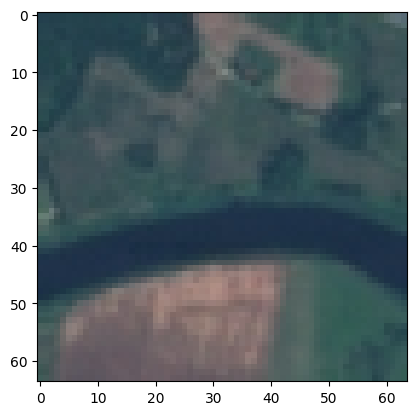


Class -> River


In [ ]:
i = rn.randint(0, len(images)-1)

image = images[i]
label = labels[i]

sample = np.array(image[0], dtype=np.uint8)
imshow(Image.fromarray(sample))
plt.show()

actual = classes[np.argmax(label)]

print(f"\nClass -> {actual}")

To visualize what each Conv2D layer learned, create a Model which use those layers as Output, and let it predict one image. Then visualize their outputs to see what each filter is for.

# Model3

In [ ]:
modelPath = os.path.join(MODELS_DIR, "Model3.h5")
model = models.load_model(modelPath)
pred = np.argmax(model.predict(image))

print(f"Model3 prediction -> {classes[pred]}")

1/1 [==============================] - 0s 102ms/step
Model3 prediction -> River


In [ ]:
outNames, outLayers = get_layer_names_and_outputs(model)
visualizator = keras.Model(inputs = model.input, outputs=outLayers)

activations = visualizator.predict(image)
for out in activations:
  print(out.shape)

1/1 [==============================] - 0s 91ms/step
(1, 62, 62, 32)
(1, 31, 31, 32)
(1, 29, 29, 64)
(1, 14, 14, 64)
(1, 12, 12, 128)
(1, 6, 6, 128)


From the **activations** variable, we can see what is the output from each Conv2D layer, and display the result as images

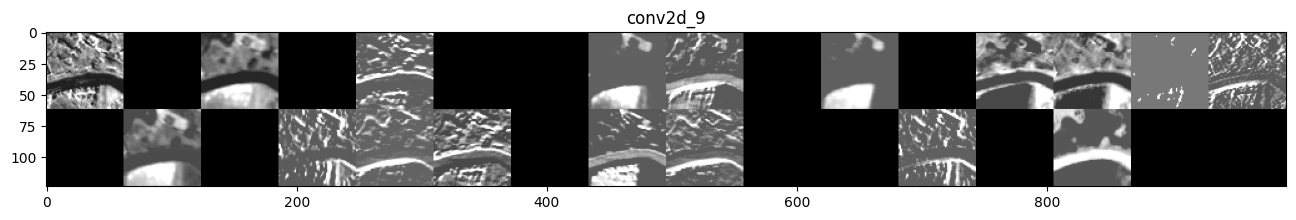

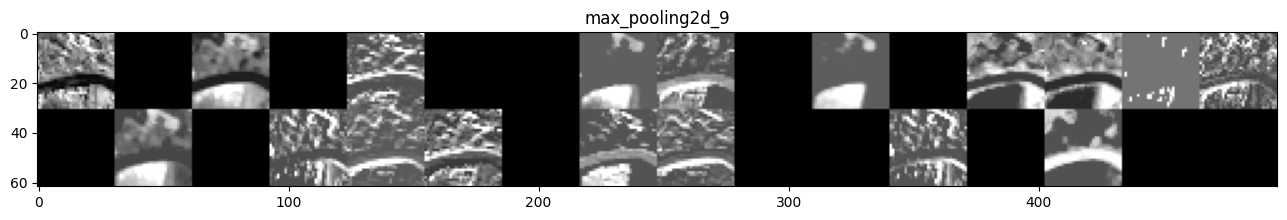

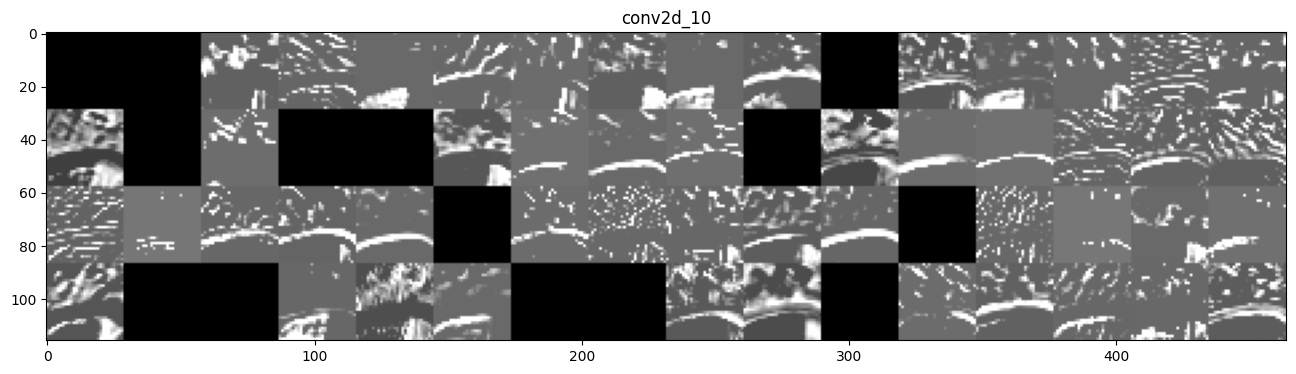

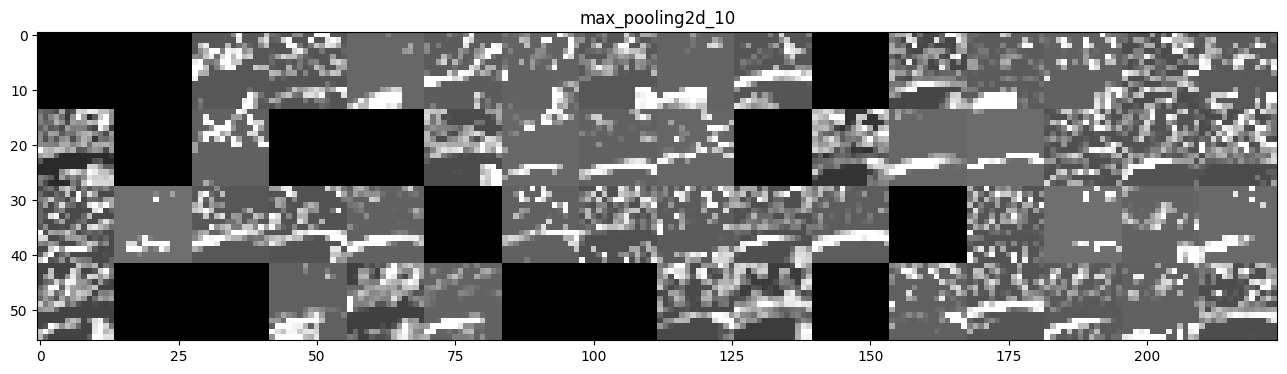

<ipython-input-61-e97baecdfcfe>:67: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


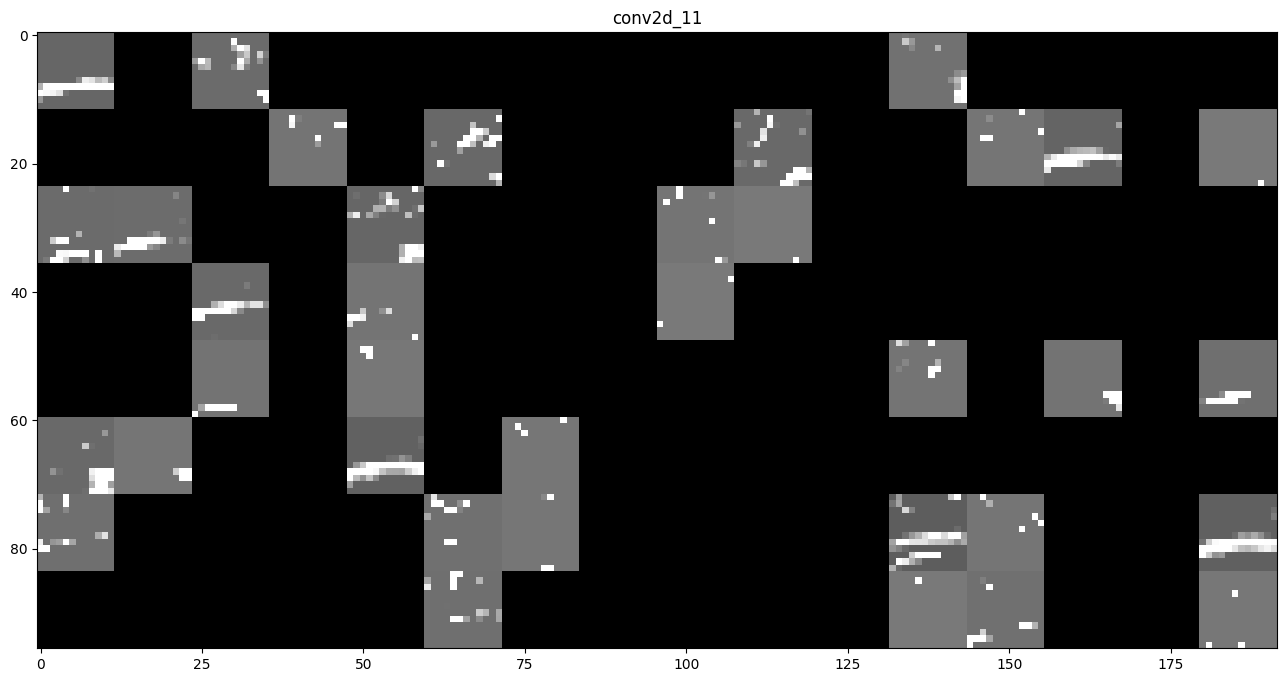

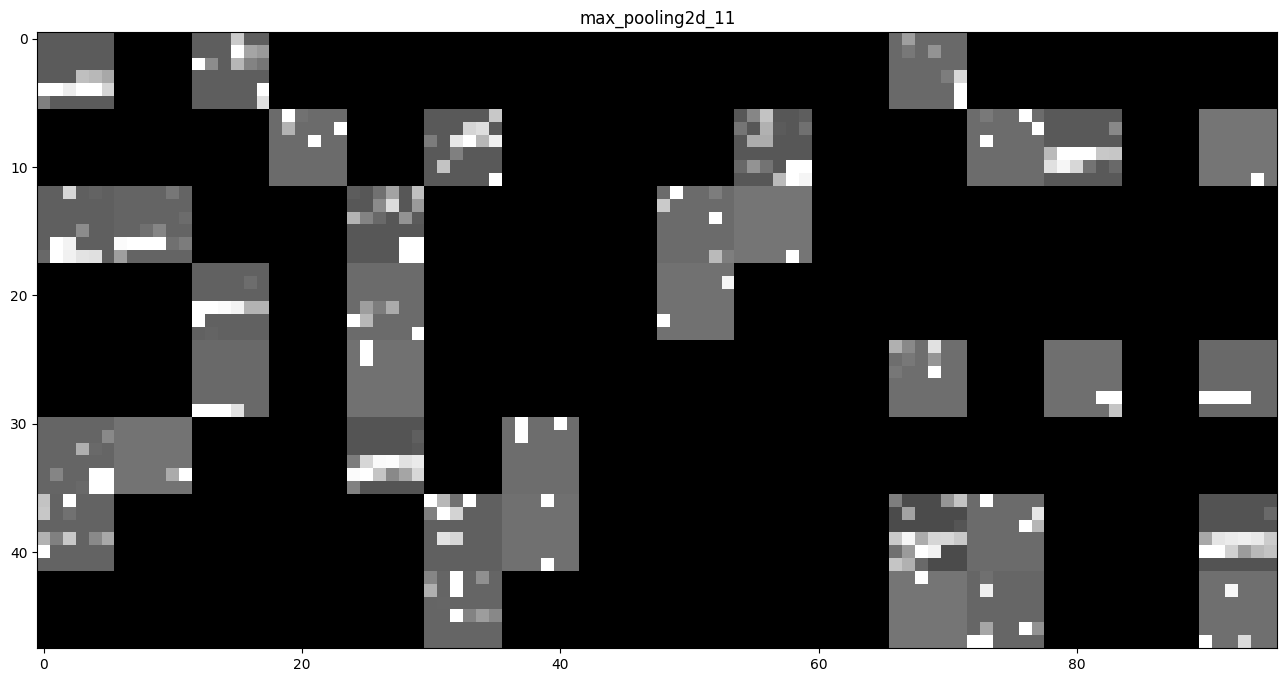

In [ ]:
intermediate_activations(outNames, activations, 16, 6)

Now, to display the activation heatmap, let's create a model using original inputs as input and last Conv2D layer as output from the original model

Then create another model that has as input layer with the same shape of last Conv2D, and for other layers, the same layers after the last Conv2D in the original model.

<ipython-input-61-e97baecdfcfe>:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


Text(0.5, 1.0, 'Gradcam')

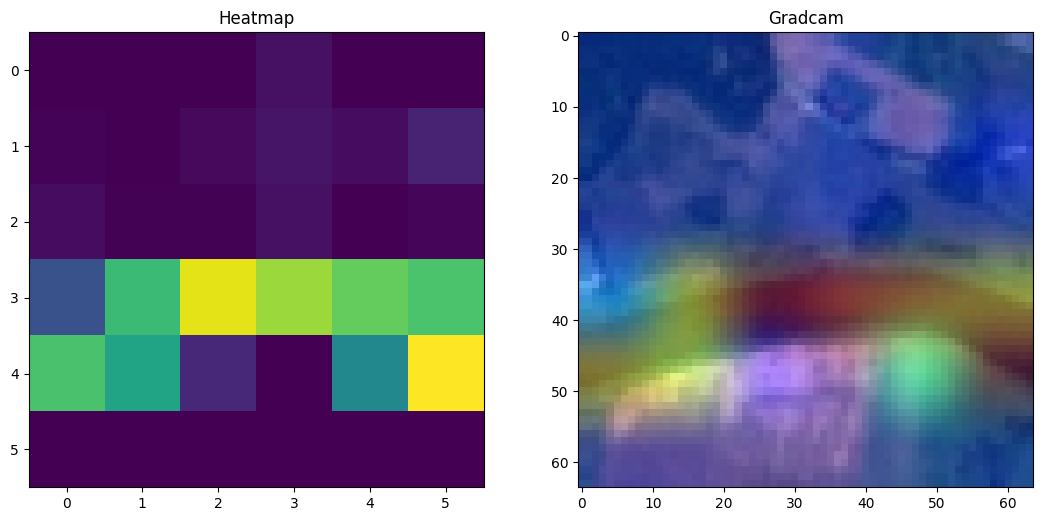

In [ ]:
heatmap = make_heatmap(image[0], model)
gradcam = compute_gradcam(image[0], heatmap)

fig = plt.figure(figsize=(13,13))

fig.add_subplot(2, 2, 1)
plt.imshow(heatmap)
plt.title("Heatmap")

fig.add_subplot(2, 2, 2)
plt.imshow(gradcam)
plt.title("Gradcam")

We can print the produced heatmap on top of the tested image to see what causes in the image the activation of given class

# VGG16

In [ ]:
modelPath = os.path.join(MODELS_DIR, "vgg16_final.h5")
model = models.load_model(modelPath)
pred = np.argmax(model.predict(image))

print(f"VGG16 prediction -> {classes[pred]}")
vgg16 = model.get_layer("vgg16")

1/1 [==============================] - 0s 244ms/step
VGG16 prediction -> River


In [ ]:
outNames, outLayers = get_layer_names_and_outputs(vgg16)
visualizator = keras.Model(inputs = vgg16.input, outputs=outLayers)

activations = visualizator.predict(image)
for out in activations:
  print(out.shape)

1/1 [==============================] - 0s 321ms/step
(1, 64, 64, 64)
(1, 64, 64, 64)
(1, 32, 32, 64)
(1, 32, 32, 128)
(1, 32, 32, 128)
(1, 16, 16, 128)
(1, 16, 16, 256)
(1, 16, 16, 256)
(1, 16, 16, 256)
(1, 8, 8, 256)
(1, 8, 8, 512)
(1, 8, 8, 512)
(1, 8, 8, 512)
(1, 4, 4, 512)
(1, 4, 4, 512)
(1, 4, 4, 512)
(1, 4, 4, 512)
(1, 2, 2, 512)


In [ ]:
intermediate_activations(outNames, activations, images_per_row = 12)

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-61-e97baecdfcfe>:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


Text(0.5, 1.0, 'Gradcam')

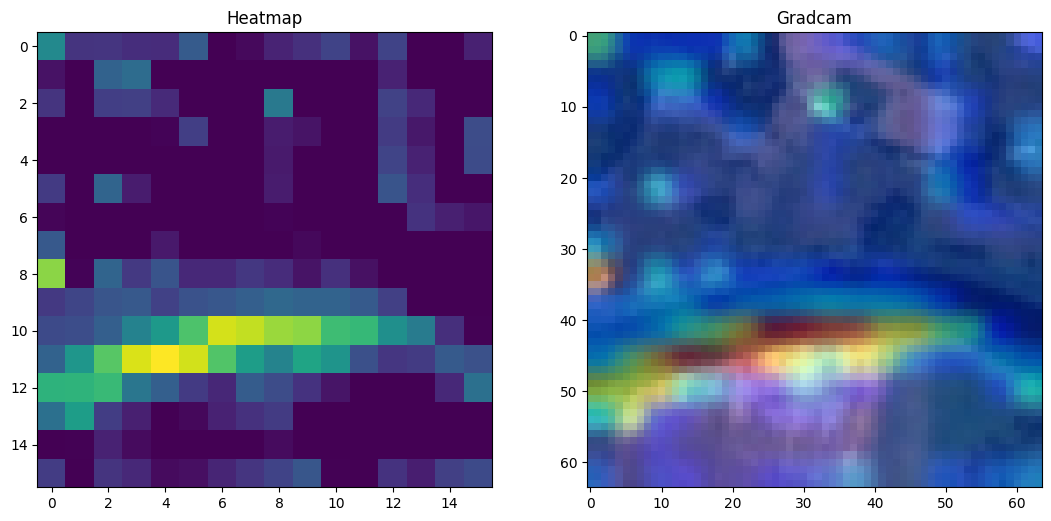

In [ ]:
# heatmap = make_heatmap(image[0], model)
heatmap = make_heatmap_inside(image[0], model, 6)
gradcam = compute_gradcam(image[0], heatmap)

fig = plt.figure(figsize=(13,13))

fig.add_subplot(2, 2, 1)
plt.imshow(heatmap)
plt.title("Heatmap")

fig.add_subplot(2, 2, 2)
plt.imshow(gradcam)
plt.title("Gradcam")

# ResNet50

In [ ]:
modelPath = os.path.join(MODELS_DIR, "resnet50_final.h5")
model = models.load_model(modelPath)
pred = np.argmax(model.predict(image))

print(f"ResNet50 prediction -> {classes[pred]}")
resnet50 = model.get_layer("resnet50")

1/1 [==============================] - 1s 1s/step
ResNet50 prediction -> River


In [ ]:
outNames, outLayers = get_layer_names_and_outputs(resnet50)

visualizator = keras.Model(inputs = resnet50.input, outputs=outLayers)

activations = visualizator.predict(image)
for out in activations:
  print(f"{out.shape}")

1/1 [==============================] - 1s 1s/step
(1, 32, 32, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 256)
(1, 16, 16, 256)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 256)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 256)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 512)
(1, 8, 8, 512)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 512)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 512)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 512)
(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 4, 4, 1024)
(1, 4, 4, 1024)
(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 4, 4, 1024)
(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 4, 4, 1024)
(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 4, 4, 1024)
(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 4, 4, 1024)
(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 4, 4, 1024)
(1, 2, 2, 512)
(1, 2, 2, 512)
(1, 2, 2, 2048)
(1, 2, 2, 2048)
(1, 2, 2, 512)
(1, 2, 2, 512)
(1, 2, 2, 2048)
(1, 2, 2, 512)
(1, 2, 2, 512)
(1, 2, 2, 2048)


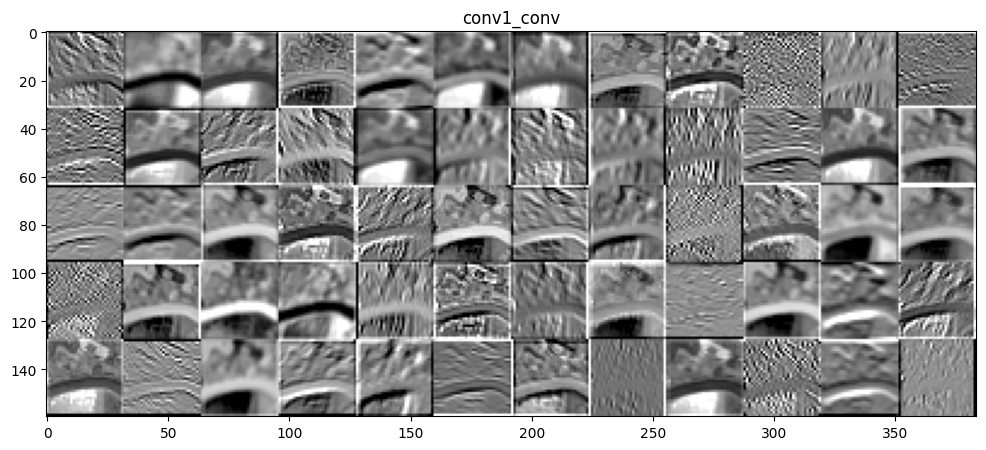

<ipython-input-61-e97baecdfcfe>:67: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


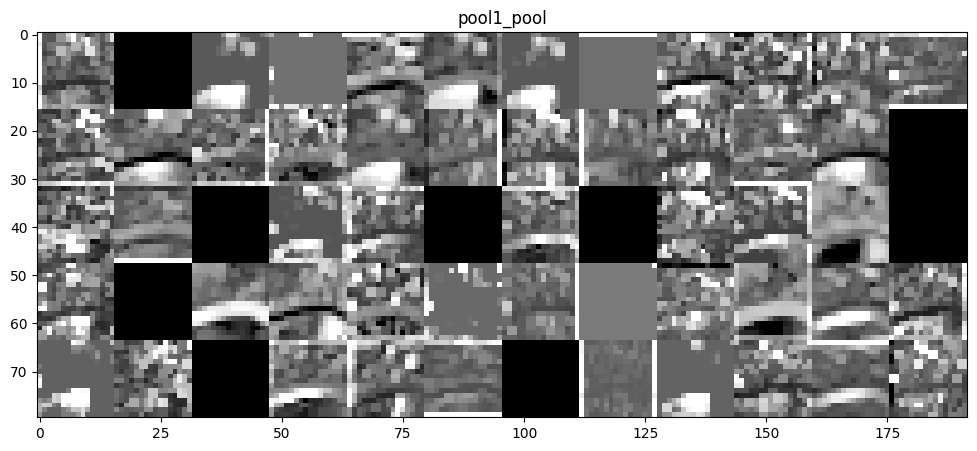

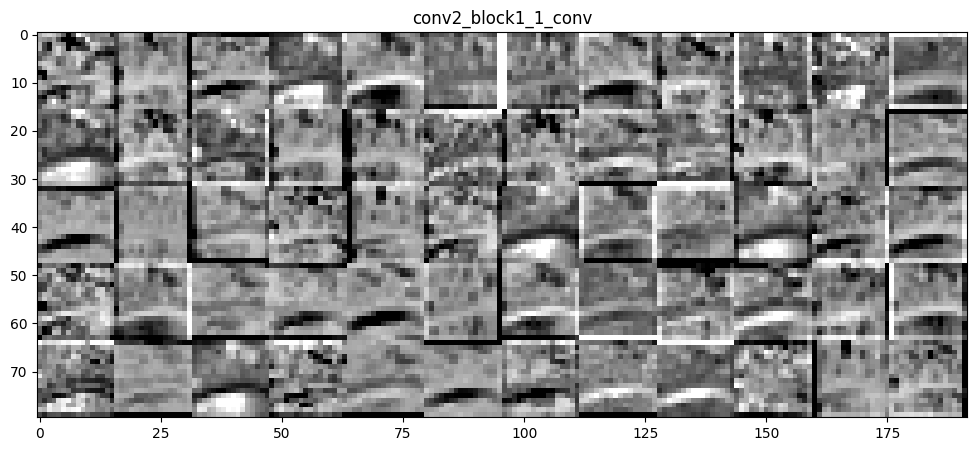

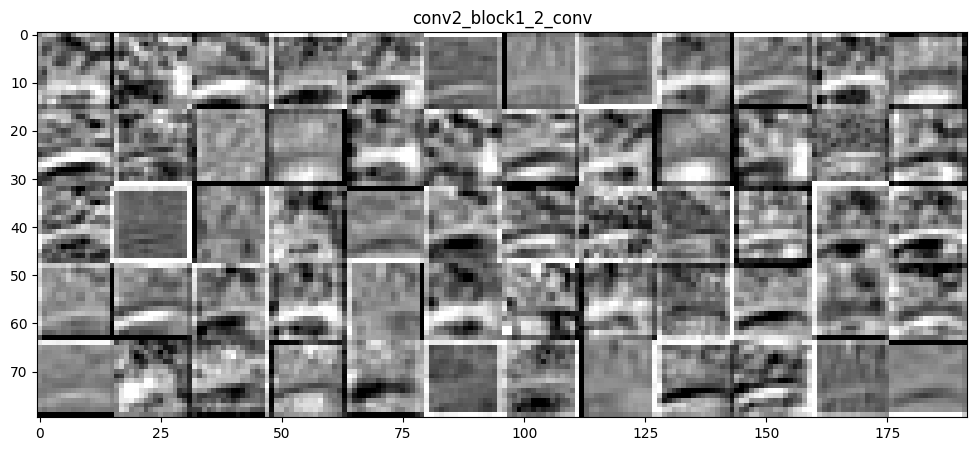

In [ ]:
intermediate_activations(outNames, activations, images_per_row = 12)

<ipython-input-61-e97baecdfcfe>:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


Text(0.5, 1.0, 'Gradcam')

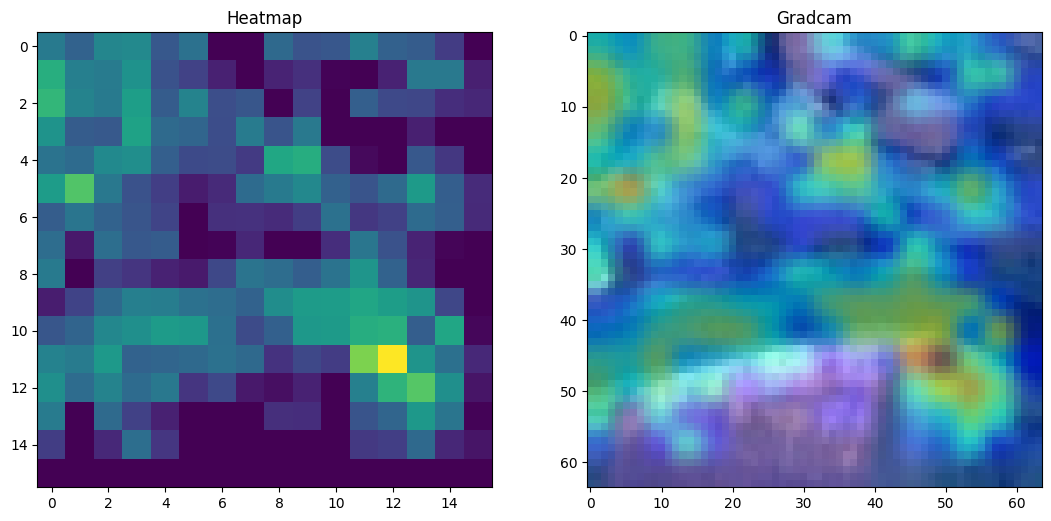

In [ ]:
# heatmap = make_heatmap(image[0], model)
heatmap = make_heatmap_inside(image[0], model, 27)
gradcam = compute_gradcam(image[0], heatmap)

fig = plt.figure(figsize=(13,13))

fig.add_subplot(2, 2, 1)
plt.imshow(heatmap)
plt.title("Heatmap")

fig.add_subplot(2, 2, 2)
plt.imshow(gradcam)
plt.title("Gradcam")